In [207]:
# %pip install aiohttp
# %pip install mysql-connector-python
# %pip install nest_asyncio
# %pip install lenskit --upgrade

In [5]:
import asyncio
import aiohttp
import json
import sqlite3
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String
import urllib
from pandas.io import sql
from datetime import datetime
import numpy as np
import requests
from time import perf_counter
import matplotlib.pyplot as plt
import nest_asyncio
nest_asyncio.apply()

# Performance Testing

In [6]:
class ConfigReader:
    def get_value(self, key):
        with open('config.json') as json_data_file:
            data = json.load(json_data_file)
        return data[key]

In [7]:
class DbManager:
    def __init__(self):
        reader = ConfigReader()
        db_connection = reader.get_value("db_connection")        
        self.conn_string = '{db_engine}{connector}://{user}:{password}@{server}/{database}'.format(
            db_engine=db_connection['db_engine'],
            connector=db_connection['connector'],
            user=db_connection['user'],
            password=db_connection['password'],
            server=db_connection['server'],
            database=db_connection['database'])

    def get_users(self):
        return sql.read_sql("SELECT distinct userId FROM ratings;", create_engine(self.conn_string))

## Get random users

In [8]:
n_rand_users = 100
dbManager = DbManager()
db_users = dbManager.get_users()
n_rand_users = db_users.sample(n=n_rand_users)

## Test recommendation endpoint

In [9]:
base_url = 'http://127.0.0.1:8000'
algo_rec = 'popular'
algo_pred = 'itemitem' # 'biasedmf'
n_recs = 5
items = "10,20,30,40,50"
pred_algos = ['bias','itemitem','useruser','biasedmf','implicitmf','funksvd','bpr']
rec_algos = ['popular']

### Semaphore performance

In [37]:
#from random import randint
import os
throughputs = []

def print_stats(times, time_taken_all, num_requests):
    print(f'Total response time: {time_taken_all}')
    print(f'Throughput (requests per second): {num_requests / time_taken_all}')
    print(f'Peak response time: {max(times)}')
    print(f'Mean response time: {np.mean(times)}')
    print(f'99 percentile: {np.quantile(times, 0.99)}')

def plot_numbers(file_name):
    resp_time_per_request = np.genfromtxt(file_name, delimiter=',')
    plt.plot(resp_time_per_request)
    plt.show()

# Predictions    
async def get_preds_sem(num_sem, file_name=None, add_throughput=False):
    times = []
    sem = asyncio.Semaphore(num_sem)
    tasks = []    
    num_requests = len(n_rand_users)
    print(f'Number of requests: {num_requests}')
    start_preds = perf_counter()

    async with aiohttp.ClientSession() as session:
        for idx, row in n_rand_users.iterrows():
            task = asyncio.ensure_future(get_user_preds_with_sem(row['userId'], algo_pred, items, session, sem, times))
            tasks.append(task)         

        responses = await asyncio.gather(*tasks)
        time_taken_all = perf_counter() - start_preds
        print_stats(times, time_taken_all, num_requests)
        
        if file_name != None and file_name != '':
            if os.path.exists(file_name):
                os.remove(file_name)
            np.asarray(times)
            np.savetxt(file_name, times, delimiter=',')
        
        if add_throughput:
            throughputs.append(num_requests / time_taken_all)

async def get_user_preds_with_sem(userId, algo, items, session, sem, times):
    async with sem:  # semaphore limits num of simultaneous downloads
        return await get_user_preds_sem(userId, algo, items, session, times)        
        
async def get_user_preds_sem(userId, algo, items, session, times):
    url = f'{base_url}/algorithms/{algo}/predictions?user_id={userId}&items={items}'
    start = perf_counter()
    async with session.get(url) as resp:
        data = await resp.json()    
        time_taken = perf_counter() - start
        times.append(time_taken)
        
# Recommendations
async def get_recs_sem(num_sem, file_name=None, add_throughput=False):
    times = []
    sem = asyncio.Semaphore(num_sem)
    tasks = []    
    num_requests = len(n_rand_users)
    print(f'Number of requests: {num_requests}')
    start_preds = perf_counter()

    async with aiohttp.ClientSession() as session:
        for idx, row in n_rand_users.iterrows():
            task = asyncio.ensure_future(get_user_recs_with_sem(row['userId'], algo_pred, n_recs, session, sem, times))
            tasks.append(task)         

        responses = await asyncio.gather(*tasks)
        time_taken_all = perf_counter() - start_preds
        print_stats(times, time_taken_all, num_requests)
        
        if file_name != None and file_name != '':
            if os.path.exists(file_name):
                os.remove(file_name)
            np.asarray(times)
            np.savetxt(file_name, times, delimiter=',')
        
        if add_throughput:
            throughputs.append(num_requests / time_taken_all)

async def get_user_recs_with_sem(userId, algo, n_recs, session, sem, times):
    async with sem:  # semaphore limits num of simultaneous downloads
        return await get_user_preds_sem(userId, algo, n_recs, session, times)        
        
async def get_user_recs_sem(userId, algo, n_recs, session, times):
    url = f'{base_url}/algorithms/{algo}/recommendations?user_id={userId}&num_recs={n_recs}'
    start = perf_counter()
    async with session.get(url) as resp:
        data = await resp.json()    
        time_taken = perf_counter() - start
        times.append(time_taken)   

### Warm up phase

In [13]:
num_workers = 24
warm_up_user = 1
times = []
async with aiohttp.ClientSession() as session:
    for algo in pred_algos:
        for w in range(num_workers):
            print(f'Calling {algo}. Worker number: {w + 1}')
            get_user_preds_sem(warm_up_user, algo, items, session, times)

Calling bias. Worker number: 1
Calling bias. Worker number: 2
Calling bias. Worker number: 3
Calling bias. Worker number: 4
Calling bias. Worker number: 5
Calling bias. Worker number: 6
Calling bias. Worker number: 7
Calling bias. Worker number: 8
Calling bias. Worker number: 9
Calling bias. Worker number: 10
Calling bias. Worker number: 11
Calling bias. Worker number: 12
Calling bias. Worker number: 13
Calling bias. Worker number: 14
Calling bias. Worker number: 15
Calling bias. Worker number: 16
Calling bias. Worker number: 17
Calling bias. Worker number: 18
Calling bias. Worker number: 19
Calling bias. Worker number: 20
Calling bias. Worker number: 21
Calling bias. Worker number: 22
Calling bias. Worker number: 23
Calling bias. Worker number: 24
Calling itemitem. Worker number: 1
Calling itemitem. Worker number: 2
Calling itemitem. Worker number: 3
Calling itemitem. Worker number: 4
Calling itemitem. Worker number: 5
Calling itemitem. Worker number: 6
Calling itemitem. Worker number

/Users/carlos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: coroutine 'get_user_preds_sem' was never awaited
  # This is added back by InteractiveShellApp.init_path()


### Call server using different semaphore numbers

#### Predictions

Number of requests: 100
Total response time: 0.28604361599991535
Throughput (requests per second): 349.5970348802666
Peak response time: 0.0066064860000096814
Mean response time: 0.0026039941599992743
99 percentile: 0.005189047560021443


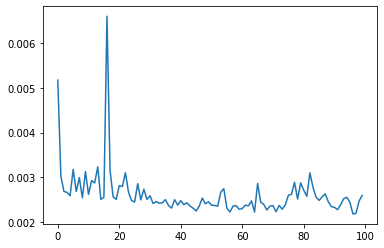

In [26]:
file_name = 'parallel_sem_1_resp_time_workers_4.csv'
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(get_preds_sem(1, file_name))
loop.run_until_complete(future)
plot_numbers(file_name)

Number of requests: 100
Total response time: 0.19100297500017405
Throughput (requests per second): 523.5520546206617
Peak response time: 0.007200359999842476
Mean response time: 0.0033358807999979943
99 percentile: 0.006343786259981248


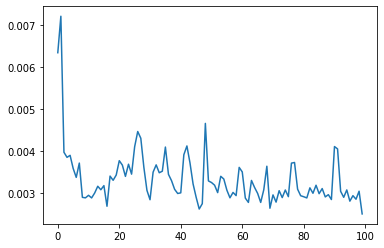

In [38]:
file_name = 'parallel_sem_2_resp_time_workers_4.csv'
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(get_preds_sem(2, file_name))
loop.run_until_complete(future)
plot_numbers(file_name)

Number of requests: 100
Total response time: 0.16980985200007126
Throughput (requests per second): 588.8939824289938
Peak response time: 0.009810345999540004


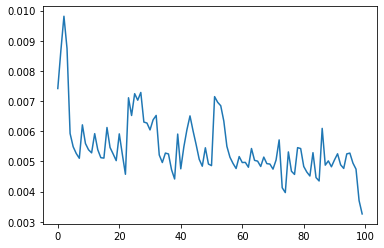

In [160]:
file_name = 'parallel_sem_4_resp_time_workers_4.csv'
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(get_preds_sem(4, file_name))
loop.run_until_complete(future)
plot_numbers(file_name)

Number of requests: 100
Total response time: 0.16102142299951083
Throughput (requests per second): 621.0353761455939
Peak response time: 0.015213088000564312


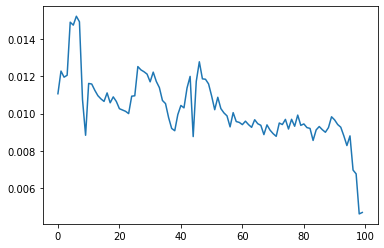

In [161]:
file_name = 'parallel_sem_8_resp_time_workers_4.csv'
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(get_preds_sem(8, file_name))
loop.run_until_complete(future)
plot_numbers(file_name)

Number of requests: 100
Total response time: 0.1554432729999462
Throughput (requests per second): 643.3215028870025
Peak response time: 0.024583342999903834


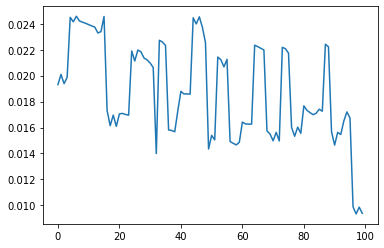

In [162]:
file_name = 'parallel_sem_16_resp_time_workers_4.csv'
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(get_preds_sem(16, file_name))
loop.run_until_complete(future)
plot_numbers(file_name)

#### Recommendations

Number of requests: 100
Total response time: 0.284021378000034
Throughput (requests per second): 352.0861728936053
Peak response time: 0.005070993000117596
Mean response time: 0.002550917199841933
99 percentile: 0.003438646349022755


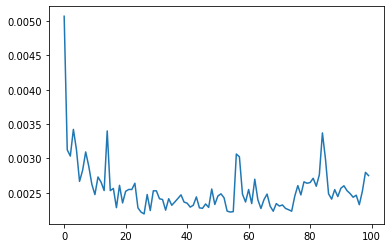

In [199]:
file_name = 'rec_parallel_sem_1_resp_time_workers_4.csv'
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(get_recs_sem(1, file_name))
loop.run_until_complete(future)
plot_numbers(file_name)

### Call server using different workers in parallel

Number of requests: 100
Total response time: 0.1671211819993914
Throughput (requests per second): 598.36819488486
Peak response time: 0.01191720700080623
Mean response time: 0.005805862480010546
99 percentile: 0.010726403319240496


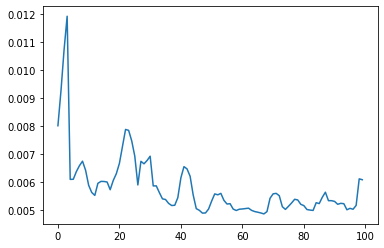

In [188]:
file_name = 'parallel_sem_4_resp_time_workers_1.csv'
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(get_preds_sem(4, file_name, True))
loop.run_until_complete(future)
plot_numbers(file_name)

Number of requests: 100
Total response time: 0.16107172400006675
Throughput (requests per second): 620.8414333477833
Peak response time: 0.011463816999821574
Mean response time: 0.005287378689990874
99 percentile: 0.01099940304995471


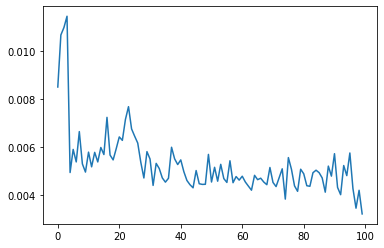

In [189]:
file_name = 'parallel_sem_4_resp_time_workers_2.csv'
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(get_preds_sem(4, file_name, True))
loop.run_until_complete(future)
plot_numbers(file_name)

Number of requests: 100
Total response time: 0.16833936300099595
Throughput (requests per second): 594.0381276089798
Peak response time: 0.00967190699884668
Mean response time: 0.005454007410025952
99 percentile: 0.009020531549795128


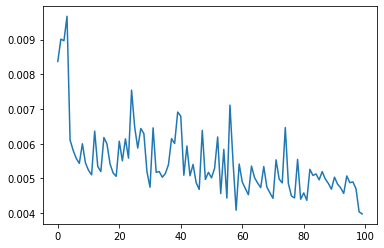

In [190]:
file_name = 'parallel_sem_4_resp_time_workers_4.csv'
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(get_preds_sem(4, file_name, True))
loop.run_until_complete(future)
plot_numbers(file_name)

Number of requests: 100
Total response time: 0.1758166479994543
Throughput (requests per second): 568.7743517912501
Peak response time: 0.010386482999820146
Mean response time: 0.0057854510200013465
99 percentile: 0.010069769129258931


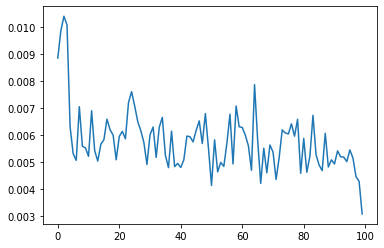

In [191]:
file_name = 'parallel_sem_4_resp_time_workers_8.csv'
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(get_preds_sem(4, file_name, True))
loop.run_until_complete(future)
plot_numbers(file_name)

Number of requests: 100
Total response time: 3.087320220000038
Throughput (requests per second): 32.39055001557266
Peak response time: 2.4714507930002583
Mean response time: 0.12097132569993846
99 percentile: 2.468961824098915


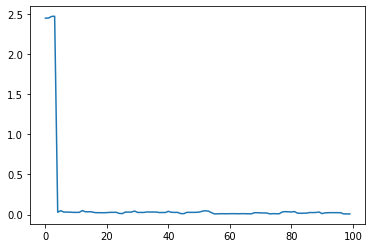

In [192]:
file_name = 'parallel_sem_4_resp_time_workers_16.csv'
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(get_preds_sem(4, file_name, True))
loop.run_until_complete(future)
plot_numbers(file_name)

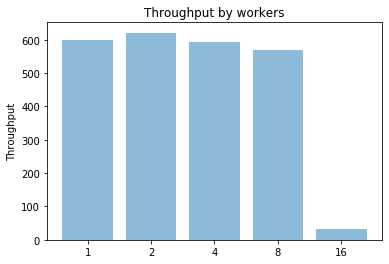

In [194]:
workers = [1, 2, 4, 8, 16]
y_pos = np.arange(len(throughputs))

plt.bar(y_pos, throughputs, align='center', alpha=0.5)
plt.xticks(y_pos, workers)
plt.ylabel('Throughput')
plt.title('Throughput by workers')

plt.show()

### Lenskit

In [33]:
import sys
import math
from binpickle import BinPickleFile
from pathlib import Path

directory_path = 'models'
algo_pred_lkpy = 'bias.bpk'

def load_for_shared_mem(file_name):
    full_file_name = Path(directory_path) / file_name

    binpickle_file = BinPickleFile(full_file_name, direct=True)
    model = binpickle_file.load()
    return model

def get_predictions_from_model(model, user, items):
    try:
        results = []
        df_preds = model.predict_for_user(user, items)
        for index, value in df_preds.iteritems():
            if not math.isnan(value):
                results.append({'item': index, 'score': value})
        return results
    except:
        print(f"Unexpected preds error for user: {user}, with items: {items}. Error: {sys.exc_info()[0]}")
        raise
        

# Predictions    
async def get_preds_sem_lkpy(num_sem, model, file_name=None, add_throughput=False):
    times = []
    sem = asyncio.Semaphore(num_sem)
    tasks = []    
    num_requests = len(n_rand_users)
    print(f'Number of requests: {num_requests}')
    start_preds = perf_counter()

    async with aiohttp.ClientSession() as session:
        for idx, row in n_rand_users.iterrows():
            task = asyncio.ensure_future(get_user_preds_with_sem_lkpy(row['userId'], algo_pred_lkpy, items, session, sem, times, model))
            tasks.append(task)         

        responses = await asyncio.gather(*tasks)
        time_taken_all = perf_counter() - start_preds
        print_stats(times, time_taken_all, num_requests)
        
        if file_name != None and file_name != '':
            if os.path.exists(file_name):
                os.remove(file_name)
            np.asarray(times)
            np.savetxt(file_name, times, delimiter=',')
        
        if add_throughput:
            throughputs.append(num_requests / time_taken_all)

async def get_user_preds_with_sem_lkpy(userId, algo, items, session, sem, times, model):
    async with sem:  # semaphore limits num of simultaneous downloads
        return await get_user_preds_sem_lkpy(userId, algo, items, session, times, model)        
        
async def get_user_preds_sem_lkpy(userId, algo, items, session, times, model):
    try:
        start = perf_counter()
        results = []
        df_preds = model.predict_for_user(userId, items.split(','))
        for index, value in df_preds.iteritems():
            if not math.isnan(value):
                results.append({'item': index, 'score': value})
                
        time_taken = perf_counter() - start
        times.append(time_taken)
        return results
    except:
        print(f"Unexpected preds error for user: {userId}, with items: {items}. Error: {sys.exc_info()[0]}")
        raise
    
    
#     url = f'{base_url}/algorithms/{algo}/predictions?user_id={userId}&items={items}'
#     start = perf_counter()
#     async with session.get(url) as resp:
#         data = await resp.json()    
#         time_taken = perf_counter() - start
#         times.append(time_taken)        
        
        

In [23]:

model = load_for_shared_mem('bias.bpk')
get_predictions_from_model(model, 10, items.split(','))

[{'item': '10', 'score': 3.5338545242691883},
 {'item': '20', 'score': 3.5338545242691883},
 {'item': '30', 'score': 3.5338545242691883},
 {'item': '40', 'score': 3.5338545242691883},
 {'item': '50', 'score': 3.5338545242691883}]

In [25]:
model = load_for_shared_mem('bias.bpk')
start_preds = perf_counter()
for idx, row in n_rand_users.iterrows():
    get_predictions_from_model(model, row['userId'], items.split(','))
end_preds = perf_counter() - start_preds
print(f'Total time: {end_preds}')

Total time: 1.2234980639999549


Number of requests: 100
Total response time: 1.35469966200003
Throughput (requests per second): 73.81709969009927
Peak response time: 0.023891112999990582
Mean response time: 0.013309768889978386
99 percentile: 0.019326406150012215


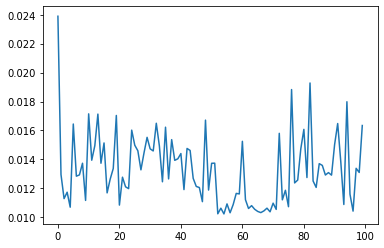

In [40]:
file_name = 'parallel_sem_2_resp_time_workers_4_lkpy.csv'
model = load_for_shared_mem('bias.bpk')
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(get_preds_sem_lkpy(1, model, file_name))
loop.run_until_complete(future)
plot_numbers(file_name)